In [153]:
# Reading and manipulation of data:
#!pip install google-colab

#from google.colab import files
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from pathlib import Path

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering

#Model prediction and assessment
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#TSNE for changing dimensions
from sklearn.manifold import TSNE

# Import XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier

#Tensorflow for neural network, and standard scaler in case we need it.
#Scaling is being done with square root so it might be redundant.
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

#Model eval
from sklearn.metrics import classification_report, roc_curve, auc, precision_score, recall_score, f1_score

In [154]:
# Define a function to provide an overview of the dataframe
def data_overview(df):
    print('Shape of the dataframe:')
    display(df.shape)
    print('First five rows of the dataframe:')
    display(df.head())
    print('Dataframe information, datatypes and missing values:')
    display(df.info())
    print('Duplicate rows in the dataframe:')
    display(df.duplicated().sum())
    print('Unique values in the dataframe:')
    display(df.nunique())
    print('Summary statistics of the dataframe:')
    display(df.describe().T.round(3))

# Define a function for a combination boxplot and histogram
def histogram_boxplot(df, feature, figsize = (8, 4), kde = False, bins = None):
        f2, (ax_box2, ax_hist2) = plt.subplots(
            nrows = 2,
            sharex = True,
            gridspec_kw = {'height_ratios': (0.25, 0.75)},
            figsize = figsize
        )
        sns.boxplot(
            data = df, x = feature, ax = ax_box2, showmeans = True, color = 'violet'
        )
        sns.histplot(
            data = df, x = feature, kde = kde, ax = ax_hist2, bins = bins if bins else 'auto'
        )
        ax_hist2.axvline(df[feature].mean(), color = 'green', linestyle = '--')
        ax_hist2.axvline(df[feature].median(), color = 'black', linestyle = '-')
        plt.tight_layout()
        plt.show()

def load_data(char_csv, delimit, char_set, doctype): # Added encoding parameter
  download_url=char_csv
  #download_url = f"https://drive.google.com/uc?id={char_csv}"
  # Added encoding='latin-1' to handle potential decoding issues
  if doctype == {}:
    df = pd.read_csv(download_url, sep=delimit, encoding=char_set)
  else:
    df = pd.read_csv(download_url, dtype=doctype, sep=delimit, encoding=char_set)
  df.columns = df.columns.str.rstrip('_')
  return df

#Null check
def check_nulls(df):
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Incompatible dataframe - needs to be Pandas")
    if df.empty:
        return False #Empty dataframe

    total_rows = df.shape[0] #Get what the totals are supposed to be
    column_count = df.count() #Non-null count series

    #Check to see if any non-null counts are less than what the totals are supposed to be
    if (column_count < total_rows).any():
        return True
    else:
        return False

def separate_df(df, key_column):
 #key_column is a unique col preserved in both so they can be rejoined
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if key_column in numeric_cols:
        numeric_cols.remove(key_column)

    cd_non_numeric = [col for col in numeric_cols if col != key_column]
    non_numericdf = df.drop(columns=cd_non_numeric).copy()

    cols_for_numeric = numeric_cols + [key_column]
    numericdf = df[cols_for_numeric].copy()

    return non_numericdf, numericdf

#Perform one hot encoding - dropping old columns
def hot_ones(df, cols):
  df_encoded = df.copy()

  for col in cols:
    # Get the number of unique values in the column
    num_unique_values = df_encoded[col].nunique()

    #Don't one hot encode values with too many possibilities
    # Check if the number of unique values is less than or equal to 52
    if num_unique_values <= 52:
      # Use dtype=int to get integer 0s and 1s instead of boolean
      one_hot = pd.get_dummies(df_encoded[col], prefix=col, dtype=int)
      df_encoded = pd.concat([df_encoded, one_hot], axis=1)
      df_encoded = df_encoded.drop(col, axis=1)

  return df_encoded

#Neural Network Model
def build_model(optimizer='adam', learning_rate=0.001):
    model = keras.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(64, activation='relu', kernel_initializer='lecun_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.3), # Add dropout
        layers.Dense(32, activation='relu', kernel_initializer='lecun_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.3), # Add dropout
        layers.Dense(1, activation='linear') #Try regression with linear activation
    ])

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        #sgd default
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9) #Momentum

    model.compile(optimizer=opt, loss='mse', metrics=['mse', 'mae'])
    return model

In [155]:
#Load char data sets and combine
pitches_df = load_data("/Users/dianasimonson/Desktop/BB/pitching_vel.csv", ',', 'utf-8', {11: str, 12:str})
#pitchers_df = load_data("/Users/dianasimonson/Desktop/BB/pitchers.csv", ',', 'utf-8', {11: str, 12:str})
#batters_df = load_data("/Users/dianasimonson/Desktop/BB/batters.csv", ',', 'utf-8', {11: str, 12:str})

# List of file IDs
#file_ids = ["/Users/dianasimonson/Downloads/pitchers.csv", "/Users/dianasimonson/Downloads/batters.csv"]

# Loop through file IDs
#for file_id in file_ids:
  # Load data for the current file ID
 # current_df = load_data(file_id, ',', 'utf-8', {11: str, 12:str})  # Set convert_col as needed
 # combined_df = pd.concat([combined_df, current_df], ignore_index=True)


In [156]:
#Visualize
pitches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318 entries, 0 to 2317
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Drop                         2316 non-null   float64
 1   Horizontal_Break             2316 non-null   float64
 2   Induced_Vertical_Break       2316 non-null   float64
 3   Pitch_Type                   2318 non-null   object 
 4   Pitch_Vel                    2318 non-null   float64
 5   In_Play                      2318 non-null   int64  
 6   Spin                         2317 non-null   float64
 7   sword_num                    2318 non-null   int64  
 8   batters::k_percent           1210 non-null   float64
 9   batters::bb_percent          1210 non-null   float64
 10  batters::woba                1210 non-null   float64
 11  batters::xwoba               1210 non-null   object 
 12  batters::sweet_spot_percent  1210 non-null   object 
 13  batters::barrel_ba

In [157]:
# Remove 'batters::' prefix from column names
pitches_df.columns = [col.replace('batters::', '') for col in pitches_df.columns]

In [158]:
pitches_df.head()

,Drop,Horizontal_Break,Induced_Vertical_Break,Pitch_Type,Pitch_Vel,In_Play,Spin,sword_num,k_percent,bb_percent,woba,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent
0,41.0,21.0,-2.0,Changeup,84.5,1,2884.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13.0,12.0,19.0,4-Seam Fastball,92.9,0,2362.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14.0,16.0,17.0,4-Seam Fastball,94.2,0,2480.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15.0,15.0,16.0,4-Seam Fastball,94.2,1,2413.0,0,23.2,5.2,0.313,.341,36.9,10.8,45.3,101.337435,94.95968,26.2,51.4
4,44.0,21.0,-3.0,Changeup,82.9,0,2736.0,0,23.2,5.2,0.313,.341,36.9,10.8,45.3,101.337435,94.95968,26.2,51.4


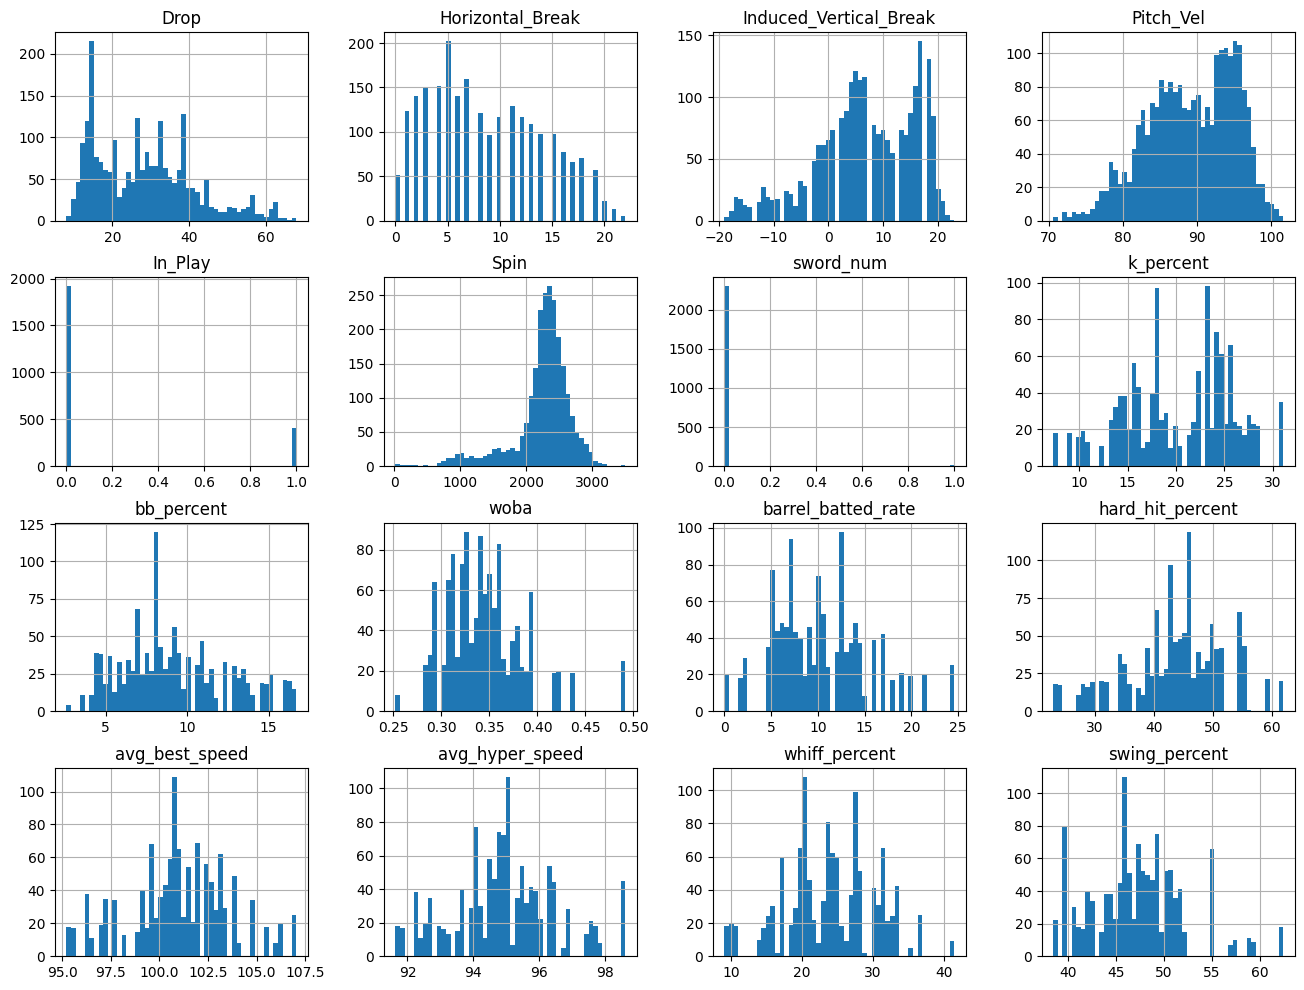

In [159]:
#Need to add headers. Re-export from FileMaker as Excel, then convert to CSV to retain headers.
#Visualize to see what else we need to do with this data.
plt.rc('font', size=12)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

pitches_df.hist(bins=50, figsize=(16, 12))
plt.show()


In [160]:
pitches_df.dropna(subset=['k_percent'], inplace=True)

In [161]:
pitches_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1210 entries, 3 to 2317
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Drop                    1210 non-null   float64
 1   Horizontal_Break        1210 non-null   float64
 2   Induced_Vertical_Break  1210 non-null   float64
 3   Pitch_Type              1210 non-null   object 
 4   Pitch_Vel               1210 non-null   float64
 5   In_Play                 1210 non-null   int64  
 6   Spin                    1210 non-null   float64
 7   sword_num               1210 non-null   int64  
 8   k_percent               1210 non-null   float64
 9   bb_percent              1210 non-null   float64
 10  woba                    1210 non-null   float64
 11  xwoba                   1210 non-null   object 
 12  sweet_spot_percent      1210 non-null   object 
 13  barrel_batted_rate      1210 non-null   float64
 14  hard_hit_percent        1210 non-null   float

In [162]:
#Separate non-numeric data for additional processing
pitches_df['PK'] = pitches_df.index
sep_dfs=separate_df(pitches_df, 'PK')
non_numericdf=sep_dfs[0]
numericdf=sep_dfs[1]

In [163]:
non_numericdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1210 entries, 3 to 2317
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Pitch_Type          1210 non-null   object
 1   xwoba               1210 non-null   object
 2   sweet_spot_percent  1210 non-null   object
 3   PK                  1210 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 47.3+ KB


In [164]:
non_numericdf.head()

,Pitch_Type,xwoba,sweet_spot_percent,PK
3,4-Seam Fastball,.341,36.9,3
4,Changeup,.341,36.9,4
14,Sinker,.374,35.8,14
15,Sweeper,.374,35.8,15
16,Sinker,.374,35.8,16


In [165]:
mean_in_play_by_pitch_type = pitches_df.groupby('Pitch_Type')['In_Play'].mean()
sorted_mean_in_play = mean_in_play_by_pitch_type.sort_values(ascending=False)
print(sorted_mean_in_play)

Pitch_Type
Changeup           0.194444
Sweeper            0.186441
Splitter           0.184615
Curveball          0.173913
4-Seam Fastball    0.170792
Slider             0.168224
Sinker             0.158974
Cutter             0.155172
Knuckle Curve      0.081967
Name: In_Play, dtype: float64


## Knuckle Curve results in a very low amount of in play balls

In [166]:
#Map values
mapping={'Knuckle Curve': 1, 'Cutter': 2, 'Sinker': 3, 'Slider': 4, '4-Seam Fastball': 5, 'Curveball': 6, 'Splitter':7, 'Sweeper':8, 'Changeup': 9}
pitches_df['Pitch_Type_num'] = pd.to_numeric(pitches_df['Pitch_Type'].map(mapping))

In [167]:
pitches_df['xwoba'] = pd.to_numeric(pitches_df['xwoba'], errors='coerce')

In [168]:
pitches_df['sweet_spot_percent'] = pd.to_numeric(pitches_df['sweet_spot_percent'], errors='coerce')

In [169]:
pitches_df['avg_best_speed'] = pd.to_numeric(pitches_df['avg_hyper_speed'], errors='coerce')

In [170]:
pitches_df['In_Play'] = np.sqrt(pitches_df['In_Play'])

In [171]:
#Drop 
#'calc_name_first','calc_name_last','calc_name_first_last','last_name_ first_name','player_id','year'
drop_cols=['Pitch_Type','sword_num','PK']
pitches_df=pitches_df.drop(columns=drop_cols)

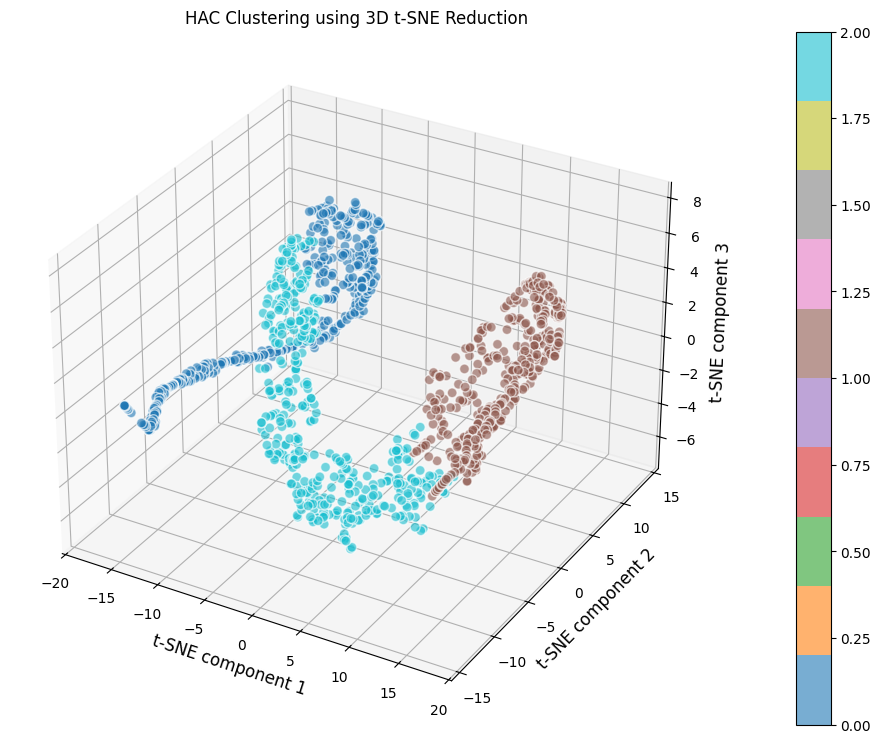

Cluster labels: [2 1 0 ... 2 2 2]
Unique labels: [0 1 2]
Number of clusters: 3
Cluster sizes: [397 382 431]


In [172]:
tsne = TSNE(n_components=3, random_state=42) # Added random_state for reproducibility
numericdf_3d = tsne.fit_transform(pitches_df) # Renamed variable for clarity

# --- Hierarchical Agglomerative Clustering (HAC) ---
# Try HAC with dimensionality reduction using the TSNE defined in the original visualization.
hac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
labels = hac.fit_predict(numericdf_3d) # Using with dimensionality reduction

# --- Visualization function (adjusted for 3D) ---
def visualize_clusters(X_3D, labels, title=""):
    fig = plt.figure(figsize=(12, 9)) # Larger figure for 3D
    ax = fig.add_subplot(111, projection='3d') # IMPORTANT: Specify 'projection='3d''

    scatter = ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2], # Use all three dimensions
                         c=labels, cmap='tab10', s=50, alpha=0.6, edgecolors='w')

    ax.set_title(title)
    ax.set_xlabel('t-SNE component 1')
    ax.set_ylabel('t-SNE component 2')
    ax.set_zlabel('t-SNE component 3') # Add z-axis label

    # Add a color bar
    fig.colorbar(scatter, ax=ax, pad=0.1) # Position colorbar appropriately

    plt.show()

# --- Visualize HAC clustering results in 3D ---
visualize_clusters(numericdf_3d, labels, title="HAC Clustering using 3D t-SNE Reduction")

print("Cluster labels:", labels)
print("Unique labels:", np.unique(labels))
print("Number of clusters:", len(np.unique(labels)))
print("Cluster sizes:", np.bincount(labels))


In [173]:
pitches_df.columns = [col.replace('batters::', '') for col in pitches_df.columns]

In [174]:
print(pitches_df.columns)

Index(['Drop', 'Horizontal_Break', 'Induced_Vertical_Break', 'Pitch_Vel',
       'In_Play', 'Spin', 'k_percent', 'bb_percent', 'woba', 'xwoba',
       'sweet_spot_percent', 'barrel_batted_rate', 'hard_hit_percent',
       'avg_best_speed', 'avg_hyper_speed', 'whiff_percent', 'swing_percent',
       'Pitch_Type_num'],
      dtype='object')



Mean values for key features in each cluster:
             Drop  Horizontal_Break  Induced_Vertical_Break  Pitch_Vel  \
labels                                                                   
0       29.198992         10.899244                6.153652  88.449370   
1       34.437173          8.222513                2.102094  87.292147   
2       22.085847          7.767981               10.222738  92.466357   

         In_Play         Spin  k_percent  bb_percent      woba     xwoba  \
labels                                                                     
0       0.181360  1811.826196  20.841814    9.581612  0.347136  0.353839   
1       0.159686  2623.094241  20.023037    8.687173  0.344874  0.350351   
2       0.160093  2320.238979  19.974014    9.325754  0.343429  0.348824   

        sweet_spot_percent  barrel_batted_rate  hard_hit_percent  \
labels                                                             
0                36.165743           10.837531         44.231990 

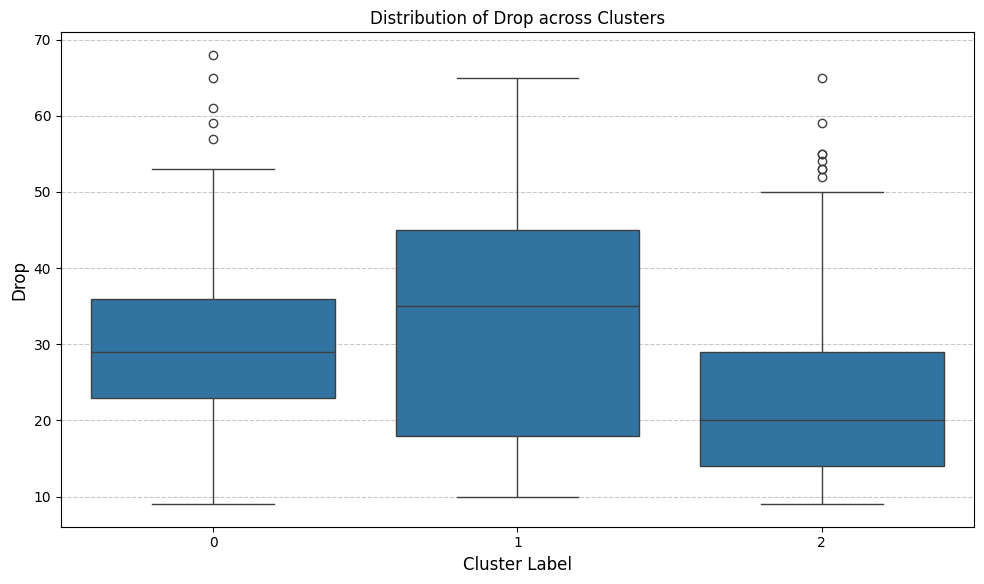

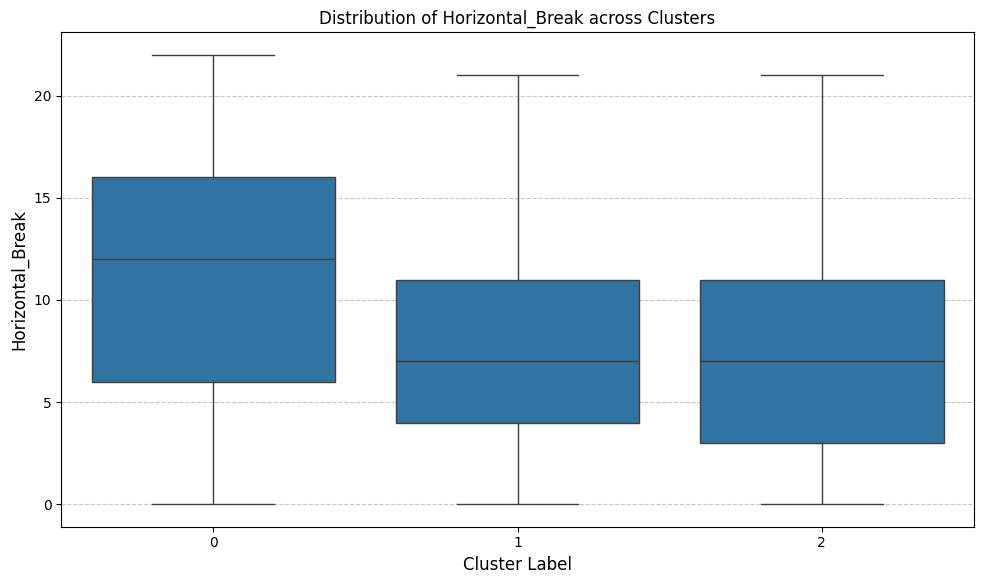

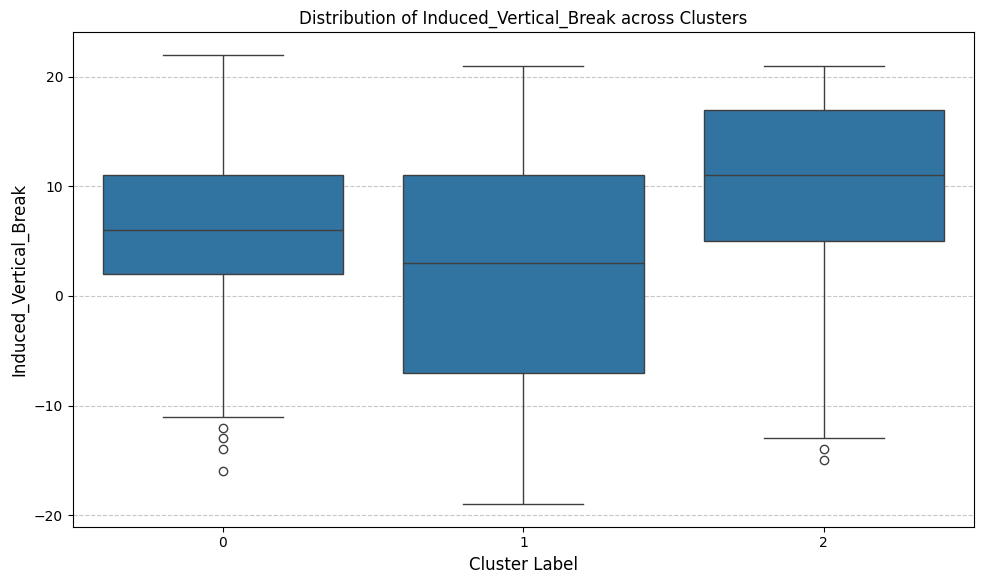

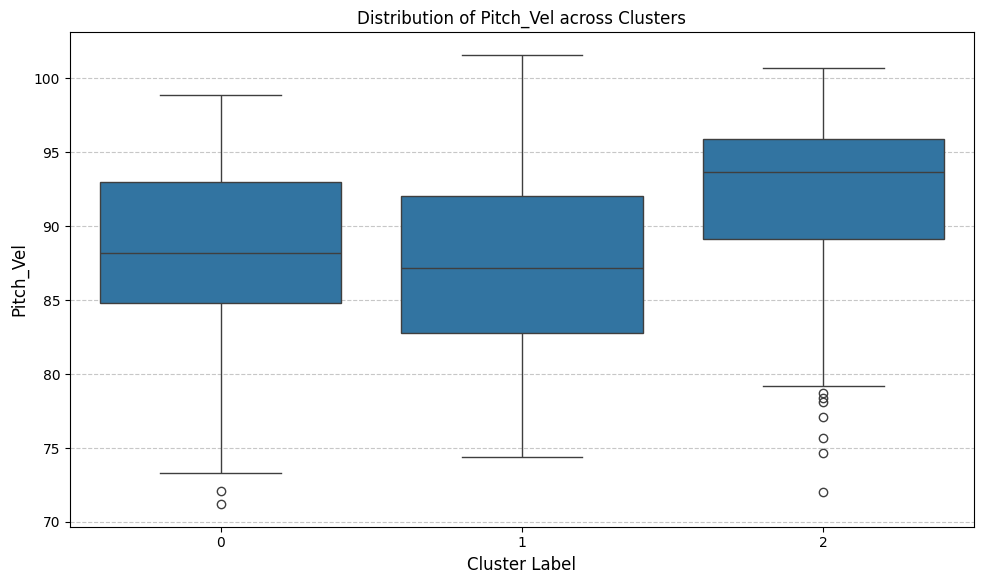

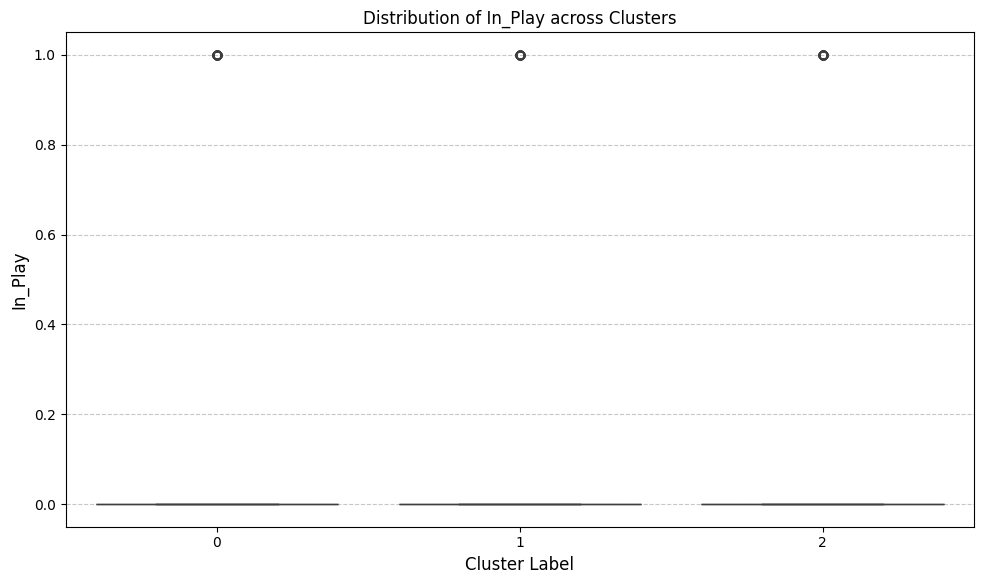

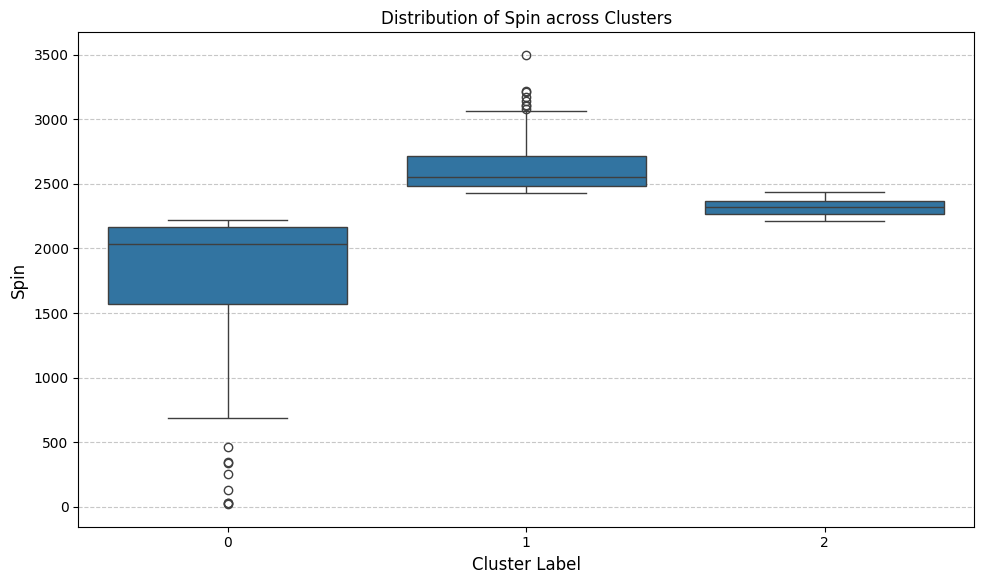

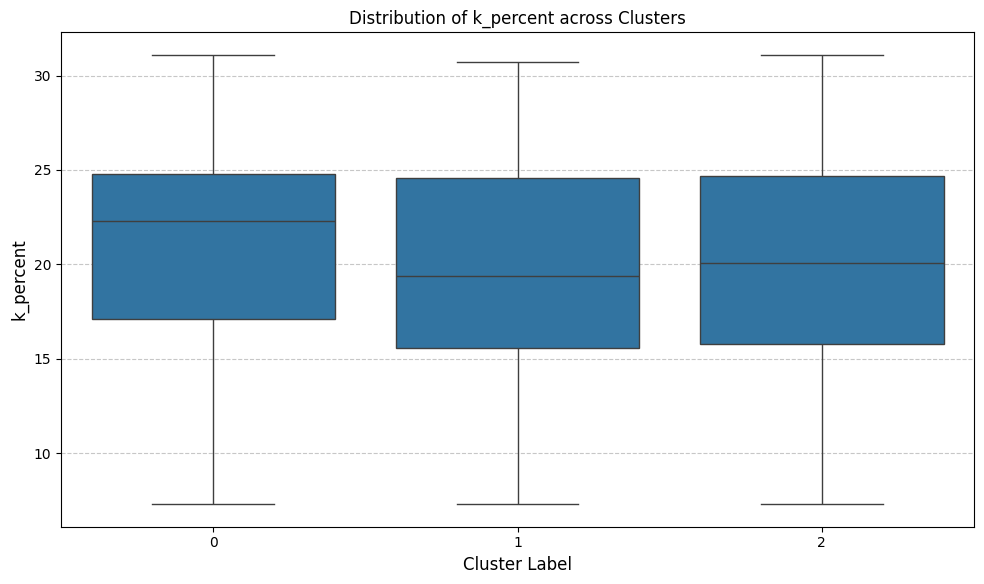

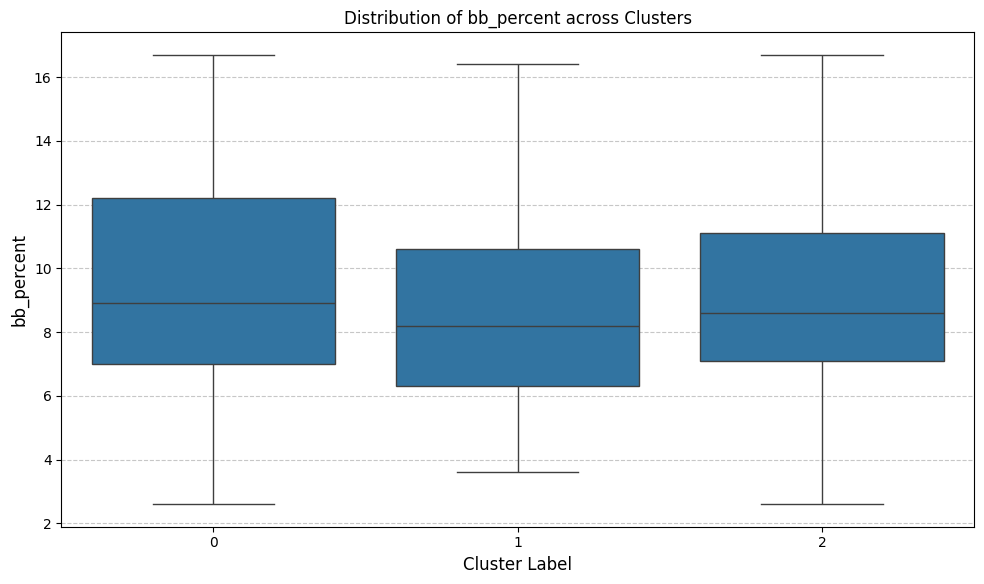

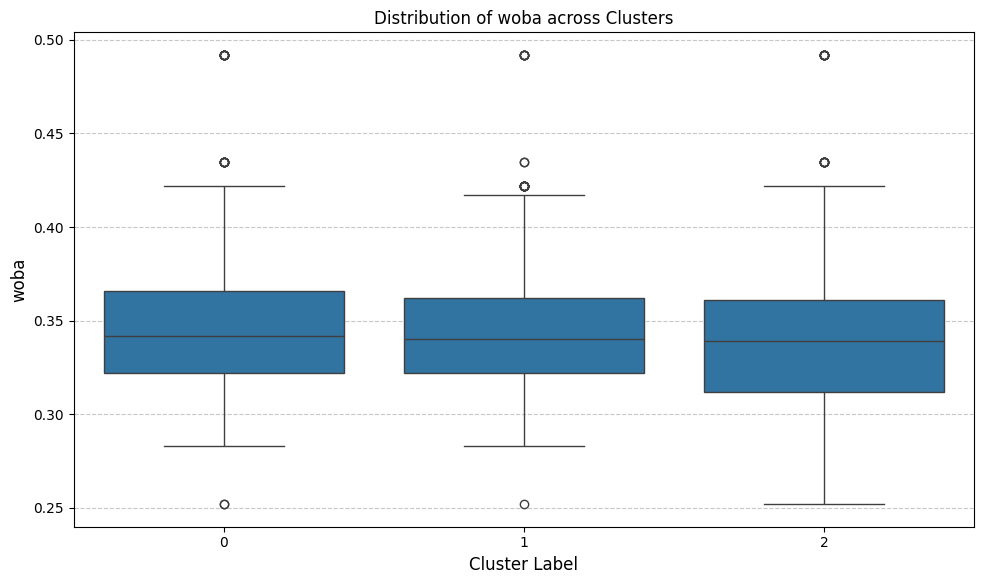

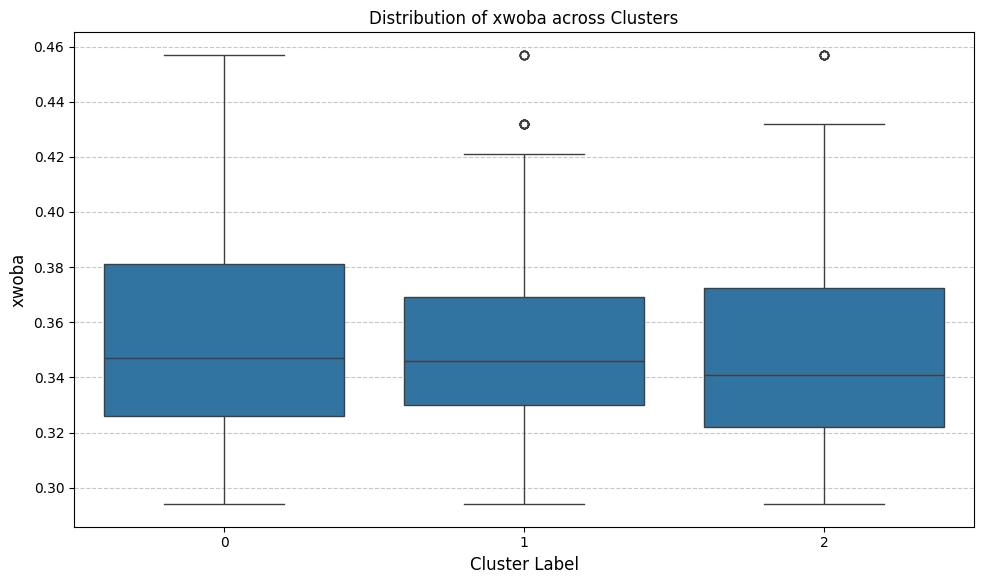

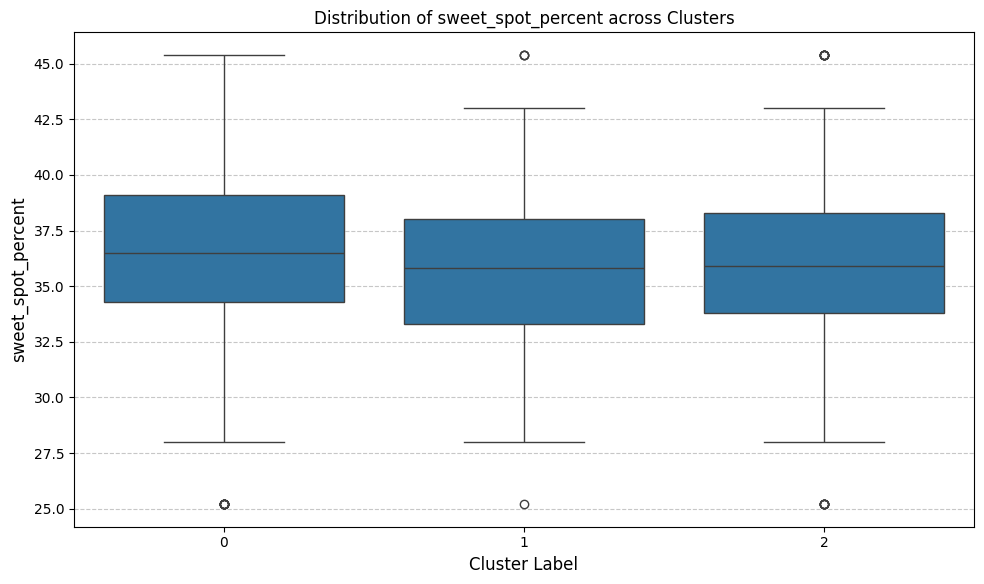

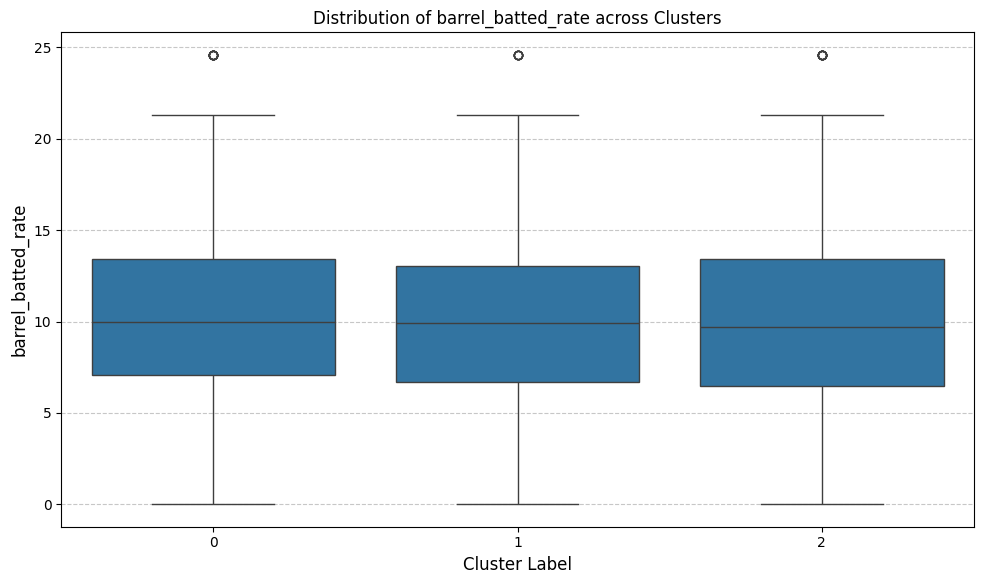

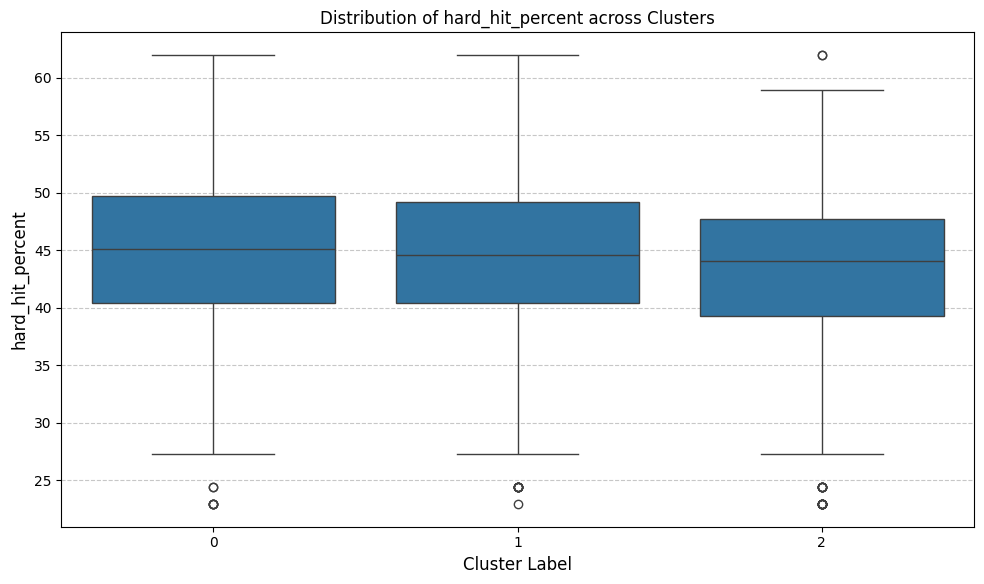

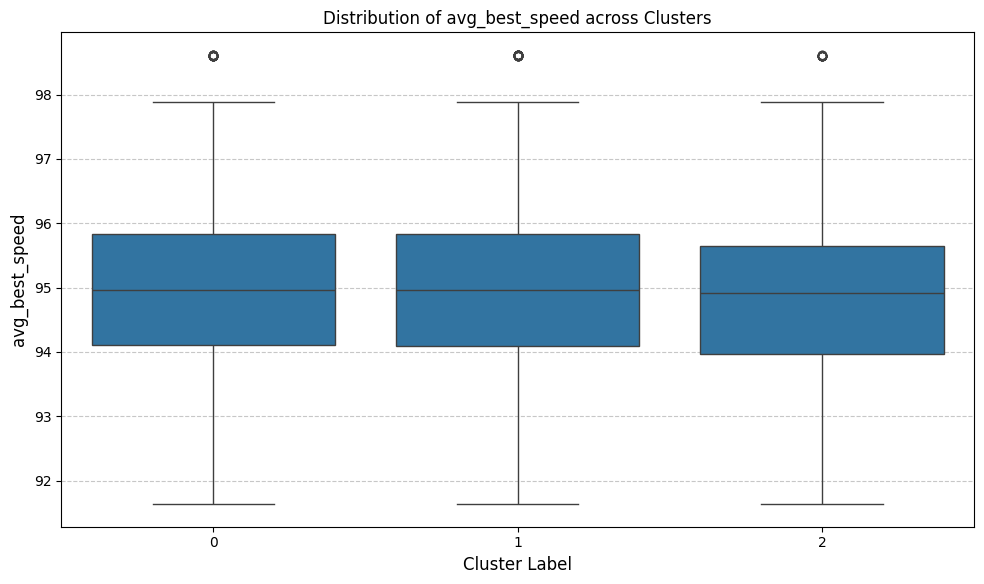

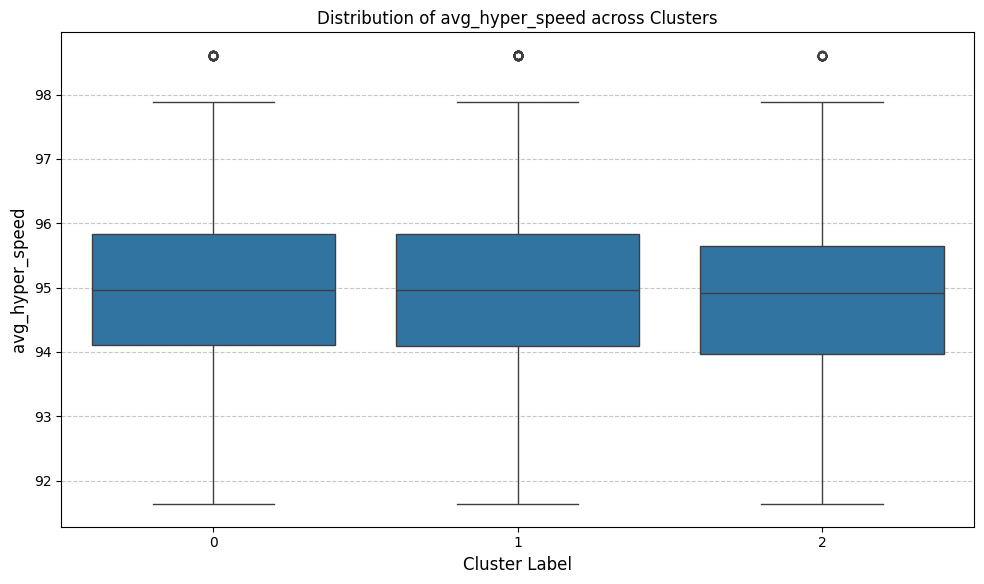

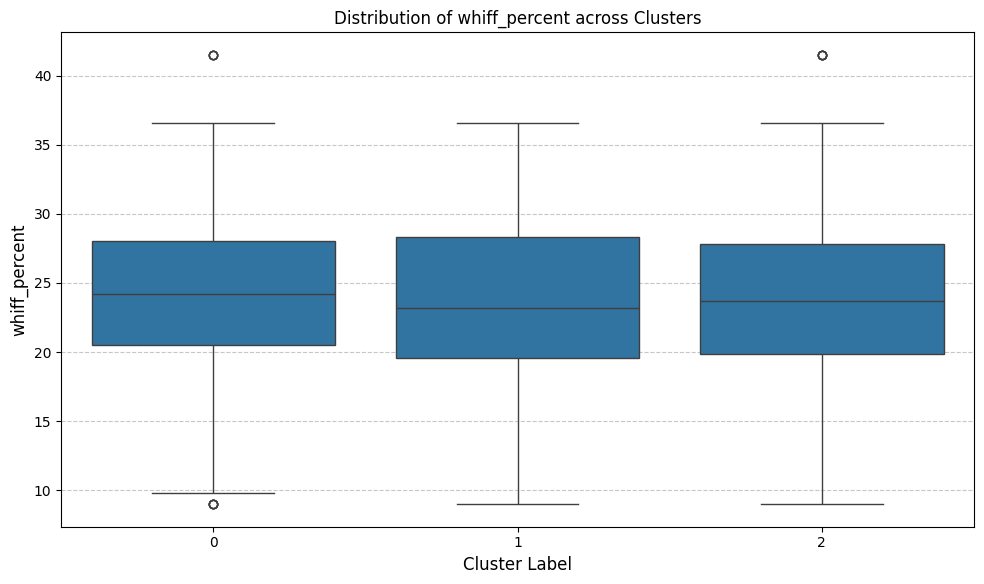

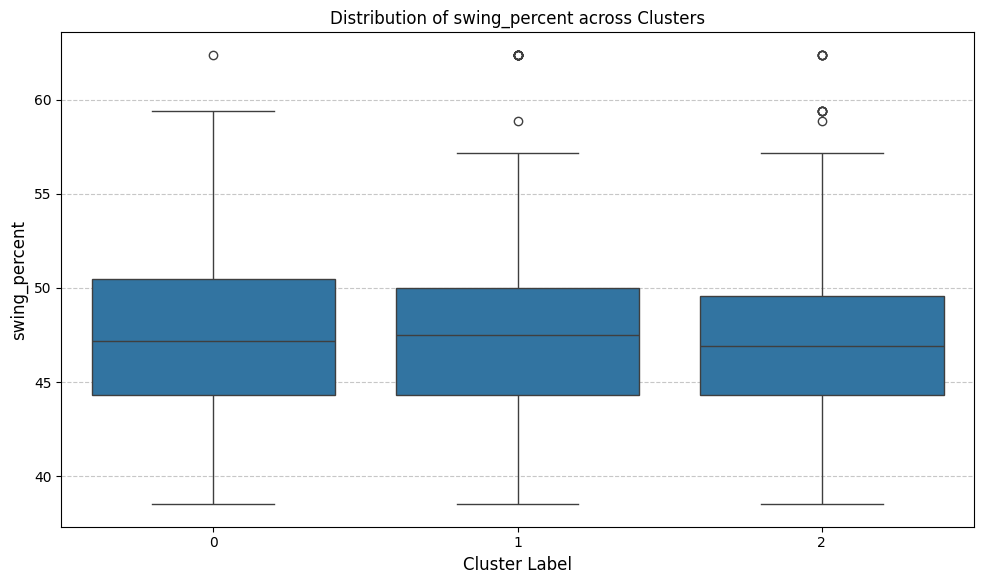

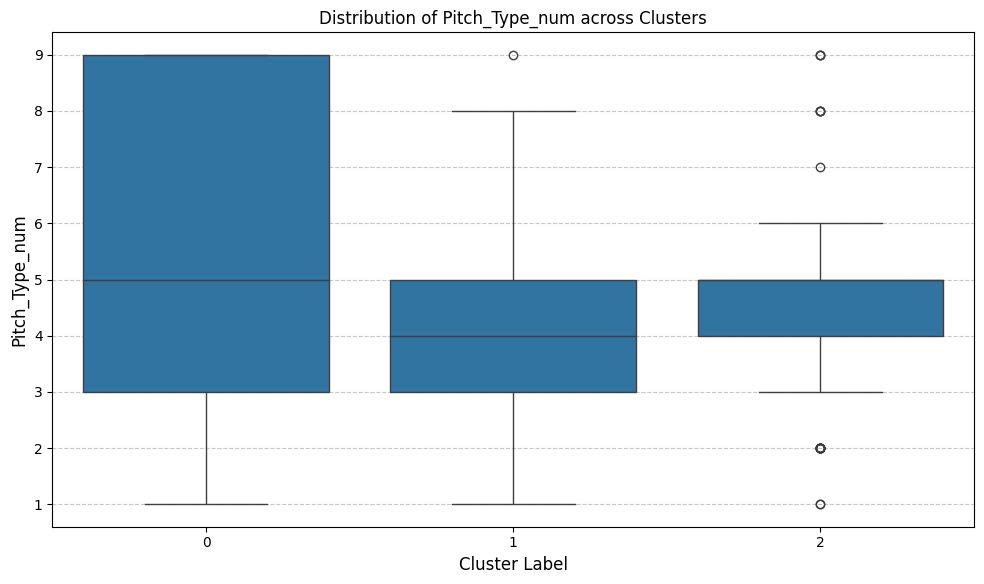


Unique labels: [0 1 2]
Number of clusters: 3
Cluster sizes: [397 382 431]


In [175]:

# Define the features to be used for clustering (all numerical features)
# Exclude 'pitch_id' if it's just an identifier
features_for_clustering = [col for col in pitches_df.columns if col != 'pitch_id']

# --- t-SNE Dimensionality Reduction to 3D (as in previous step) ---
# Use t-SNE to project the vectors into a 3D space
tsne = TSNE(n_components=3, random_state=42)
numericdf_3d = tsne.fit_transform(pitches_df[features_for_clustering])

# --- Hierarchical Agglomerative Clustering (HAC) ---
hac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
labels = hac.fit_predict(numericdf_3d)

# --- IMPORTANT: Add cluster labels to the original DataFrame ---
pitches_df['labels'] = labels

# --- Define key features to analyze in clusters ---
key_features = [
    'Drop', 'Horizontal_Break', 'Induced_Vertical_Break', 'Pitch_Vel',
    'In_Play', 'Spin', 'k_percent', 'bb_percent', 'woba',
    'xwoba', 'sweet_spot_percent', 'barrel_batted_rate', 'hard_hit_percent',
    'avg_best_speed', 'avg_hyper_speed', 'whiff_percent', 'swing_percent', 'Pitch_Type_num'
]

# --- Calculate and print mean values for key features in each cluster ---
# Group by the newly added 'labels' column
cluster_key_means = pitches_df.groupby('labels')[key_features].mean()
print("\nMean values for key features in each cluster:")
print(cluster_key_means)

# --- Visualize the distribution across the key features using boxplots ---
for feature in key_features:
    plt.figure(figsize=(10, 6)) # Adjusted figure size for better readability
    # Use 'labels' for the x-axis and pitches_df as the data source
    sns.boxplot(x='labels', y=feature, data=pitches_df)
    plt.title(f'Distribution of {feature} across Clusters')
    plt.xlabel('Cluster Label')
    plt.ylabel(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

print("\nUnique labels:", np.unique(labels))
print("Number of clusters:", len(np.unique(labels)))
print("Cluster sizes:", np.bincount(labels))


In [176]:
pitches_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1210 entries, 3 to 2317
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Drop                    1210 non-null   float64
 1   Horizontal_Break        1210 non-null   float64
 2   Induced_Vertical_Break  1210 non-null   float64
 3   Pitch_Vel               1210 non-null   float64
 4   In_Play                 1210 non-null   float64
 5   Spin                    1210 non-null   float64
 6   k_percent               1210 non-null   float64
 7   bb_percent              1210 non-null   float64
 8   woba                    1210 non-null   float64
 9   xwoba                   1210 non-null   float64
 10  sweet_spot_percent      1210 non-null   float64
 11  barrel_batted_rate      1210 non-null   float64
 12  hard_hit_percent        1210 non-null   float64
 13  avg_best_speed          1210 non-null   float64
 14  avg_hyper_speed         1210 non-null   float

In [177]:
#Select features
selected_columns = ['barrel_batted_rate','Drop', 'Horizontal_Break', 'Induced_Vertical_Break', 'Spin', 'In_Play', 'Pitch_Vel','Pitch_Type_num']
new_df = pitches_df[selected_columns]
new_df.corr()

,barrel_batted_rate,Drop,Horizontal_Break,Induced_Vertical_Break,Spin,In_Play,Pitch_Vel,Pitch_Type_num
barrel_batted_rate,1.000000,0.052063,-0.113474,-0.041781,-0.070067,-0.049866,-0.069517,-0.049032
Drop,0.052063,1.000000,0.024167,-0.965548,0.059810,-0.031835,-0.857357,-0.021667
Horizontal_Break,-0.113474,0.024167,1.000000,-0.053835,-0.165584,0.010161,0.067398,0.246957
Induced_Vertical_Break,-0.041781,-0.965548,-0.053835,1.000000,-0.113897,0.037975,0.701209,0.136828
Spin,-0.070067,0.059810,-0.165584,-0.113897,1.000000,-0.029746,0.077155,-0.365985
In_Play,-0.049866,-0.031835,0.010161,0.037975,-0.029746,1.000000,0.007060,0.047444
Pitch_Vel,-0.069517,-0.857357,0.067398,0.701209,0.077155,0.007060,1.000000,-0.202931
Pitch_Type_num,-0.049032,-0.021667,0.246957,0.136828,-0.365985,0.047444,-0.202931,1.000000


In [178]:
# Drop index and target, and separate
X = new_df.drop(['In_Play'], axis=1)
y = new_df['In_Play']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("-" * 50)

# --- 4. Define the XGBoost Regressor model ---
# We'll use a placeholder for now, as GridSearchCV will set the best params
xgb_model_base = XGBRegressor(objective='reg:squarederror',
                              random_state=42,
                              n_jobs=-1)

# --- 5. Define the parameter grid for GridSearchCV ---
# This is a good starting point. You might need to expand these ranges.
param_grid = {
    'n_estimators': [100, 200, 500], # Try more estimators
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Widen the learning rate range
    'max_depth': [3, 5, 7], # Explore different depths
    'subsample': [0.7, 0.8, 0.9], # Fraction of samples used for fitting the trees
    'colsample_bytree': [0.7, 0.8, 0.9] # Fraction of features used for fitting the trees
}

# --- 6. Initialize GridSearchCV ---
# cv=5 means 5-fold cross-validation
# scoring='r2' means it will optimize for R-squared
# verbose=1 will print progress
grid_search = GridSearchCV(estimator=xgb_model_base,
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2', # Use R-squared for optimization
                           verbose=1,
                           n_jobs=-1) # Use all available cores for grid search

# --- 7. Fit GridSearchCV to the training data ---
print("Starting GridSearchCV for hyperparameter tuning...")
grid_search.fit(X_train, y_train)
print("GridSearchCV complete.")

# --- 8. Get the best model and its parameters ---
best_xgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_ # Best R-squared from cross-validation

print(f"\nBest parameters found by GridSearchCV: {best_params}")
print(f"Best R-squared score on training data (cross-validation): {best_score:.4f}")
print("-" * 50)

# --- 9. Evaluate the best model on the test set ---
y_pred_best = best_xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"\nModel performance on the TEST set (with best parameters):")
print(f"R-squared (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print("-" * 50)

# --- Optional: Feature Importance ---
print("\nFeature Importances (from the best model):")
feature_importances = pd.Series(best_xgb_model.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))



X_train shape: (968, 7)
y_train shape: (968,)
--------------------------------------------------
Starting GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
GridSearchCV complete.

Best parameters found by GridSearchCV: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Best R-squared score on training data (cross-validation): -0.0133
--------------------------------------------------

Model performance on the TEST set (with best parameters):
R-squared (R2): 0.0031
Root Mean Squared Error (RMSE): 0.3781
--------------------------------------------------

Feature Importances (from the best model):
Horizontal_Break          0.150301
barrel_batted_rate        0.148057
Spin                      0.147438
Drop                      0.146590
Pitch_Vel                 0.139181
Induced_Vertical_Break    0.138439
Pitch_Type_num            0.129993
dtype: float32
